In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
import torch
import random
import numpy as np

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [3]:
import matplotlib.pyplot as plt
def show_images(images, scores, test_artist, train_artists):
    n: int = len(images)
    f = plt.figure(figsize=(16, 2))
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        if i==0:
            pass
            ax.title.set_text(test_artist)
        else:
            ax.title.set_text(str(np.round(scores[i-1], 4))+'\n'+train_artists[i-1])
            ax.axis('off')
        if images[i]==None:
            pass
        else:
            plt.imshow(images[i])

    plt.show(block=True)

In [4]:
from datasets import load_dataset

In [6]:
import pickle

In [7]:
with open('../../data/indices/5000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

5000

In [8]:
# with open('../../data/indices/5000-0.5/idx-val.pkl', 'rb')  as handle:
#     idx_val = pickle.load(handle)
# len(idx_val)

In [9]:
import pandas as pd
df = pd.read_csv('../../../../codes/artbench/ArtBench-10.csv')
df.head()

,name,artist,url,is_public_domain,length,width,label,split,cifar_index
0,frank-omeara_towards-night-and-winter.jpg,frank-omeara,https://uploads5.wikiart.org/00316/images/fran...,True,800,657,impressionism,train,43186
1,goldstein-grigoriy_morning.jpg,goldstein-grigoriy,https://uploads5.wikiart.org/images/grigoriy-g...,True,521,499,impressionism,train,41151
2,georges-lemmen_man-reading.jpg,georges-lemmen,https://uploads6.wikiart.org/images/georges-le...,True,800,612,impressionism,train,9754
3,theodor-aman_port-of-constantza-1882.jpg,theodor-aman,https://uploads6.wikiart.org/images/theodor-am...,True,560,336,impressionism,train,44244
4,niccolo-cannicci_il-passo-della-futa-1914.jpg,niccolo-cannicci,https://uploads3.wikiart.org/images/niccolo-ca...,True,2400,2322,impressionism,train,46885


In [10]:
df['path'] = df.apply(lambda x: "../../../../codes/artbench/data/artbench-10-imagefolder/{}/{}".format(x['label'], x['name']), axis=1)
df.head()

,name,artist,url,is_public_domain,length,width,label,split,cifar_index,path
0,frank-omeara_towards-night-and-winter.jpg,frank-omeara,https://uploads5.wikiart.org/00316/images/fran...,True,800,657,impressionism,train,43186,../../../../codes/artbench/data/artbench-10-im...
1,goldstein-grigoriy_morning.jpg,goldstein-grigoriy,https://uploads5.wikiart.org/images/grigoriy-g...,True,521,499,impressionism,train,41151,../../../../codes/artbench/data/artbench-10-im...
2,georges-lemmen_man-reading.jpg,georges-lemmen,https://uploads6.wikiart.org/images/georges-le...,True,800,612,impressionism,train,9754,../../../../codes/artbench/data/artbench-10-im...
3,theodor-aman_port-of-constantza-1882.jpg,theodor-aman,https://uploads6.wikiart.org/images/theodor-am...,True,560,336,impressionism,train,44244,../../../../codes/artbench/data/artbench-10-im...
4,niccolo-cannicci_il-passo-della-futa-1914.jpg,niccolo-cannicci,https://uploads3.wikiart.org/images/niccolo-ca...,True,2400,2322,impressionism,train,46885,../../../../codes/artbench/data/artbench-10-im...


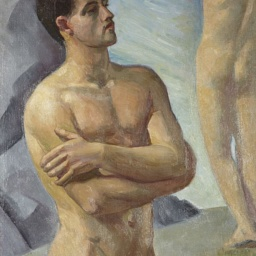

In [11]:
from datasets import Dataset, load_dataset, Image

train_dataset = Dataset.from_dict({"image": df.loc[idx_train]['path'].tolist(),
                                   "label": df.loc[idx_train]['label'].tolist(),
                                  }).cast_column("image", Image())
train_dataset[0]["image"]

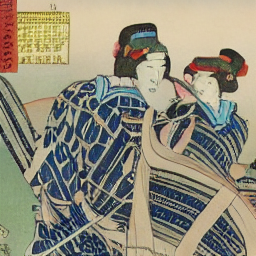

In [12]:
import pandas as pd
df = pd.DataFrame()
df['label'] = ['ukiyo_e']*500+['post_impressionism']*500
df['path'] = ['{}/{}.png'.format('../../saved/5000-0.5/gen', i) for i in range(1000)]

from datasets import DatasetDict, Dataset, load_dataset, Image
dataset = DatasetDict({
"train": Dataset.from_dict({
    "image": df['path'].tolist(),
    "label": df['label'].tolist(),
}).cast_column("image", Image()),})
val_dataset = dataset["train"]
val_dataset[0]["image"]

In [13]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.0.1+cu117


In [14]:
# !pip install git+https://github.com/openai/CLIP.git

In [15]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [16]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [17]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f0c9c087820>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [18]:
train_features = []
for i in range(0, len(train_dataset), 32):
    batch = train_dataset[i:i+32]['image']
    batch = [preprocess(b) for b in batch]
    batch = torch.tensor(np.stack(batch)).cuda()
    with torch.no_grad():
        image_features = model.encode_image(batch).float()
    print(image_features.size())
    train_features.append(image_features.cpu().numpy())

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size

In [19]:
train_features_array = np.vstack(train_features)
train_features_array.shape

(5000, 512)

In [20]:
val_features = []
for i in range(0, len(val_dataset), 32):
    batch = val_dataset[i:i+32]['image']
    batch = [preprocess(b) for b in batch]
    batch = torch.tensor(np.stack(batch)).cuda()
    with torch.no_grad():
        image_features = model.encode_image(batch).float()
    print(image_features.size())
    val_features.append(image_features.cpu().numpy())

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([8, 512])


In [21]:
val_features_array = np.vstack(val_features)
val_features_array.shape

(1000, 512)

In [22]:
scores_list = []

In [23]:
scores = val_features_array.dot(train_features_array.T)
scores_list.append(scores)

In [24]:
scores = (val_features_array/np.linalg.norm(val_features_array, axis=1).reshape(-1, 1)).dot(
    (train_features_array/np.linalg.norm(train_features_array, axis=1).reshape(-1, 1)).T
)
scores_list.append(scores)

In [25]:
with open('./gen_clip.pkl', 'wb') as handle:
    pickle.dump(scores_list, handle)

In [26]:
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [27]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/lds-val/sd-lora-sub-{}-{}/e-{}-gen.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

In [28]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/5000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 5000)

In [29]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

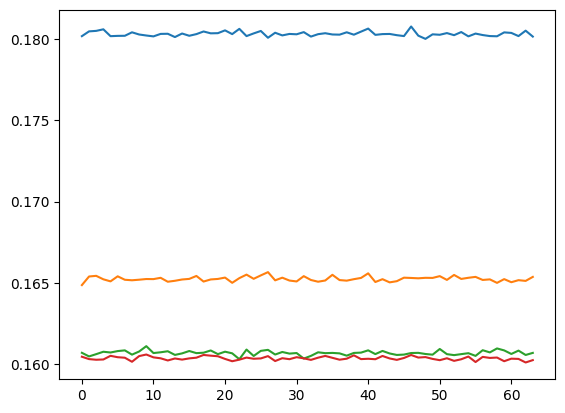

In [30]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [31]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
# k = 48
# margins = lds_testset_correctness[k:]
# infl_est_ = _masked_dot(lds_testset_correctness[:k], lds_mask_array[:k]) - _masked_dot(lds_testset_correctness[:k], ~lds_mask_array[:k])
# # infl_est_ = _masked_dot(lds_testset_correctness[:], lds_mask_array[:]) - _masked_dot(lds_testset_correctness[:], ~lds_mask_array[:])
# preds = lds_mask_array[k:] @ infl_est_.T

margins = lds_testset_correctness
np.random.seed(0)
infl_est_ = -np.random.rand(1000, 5000)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.005 (avg p value 0.501355)


In [32]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
# k = 48
# margins = lds_testset_correctness[k:]
# infl_est_ = _masked_dot(lds_testset_correctness[:k], lds_mask_array[:k]) - _masked_dot(lds_testset_correctness[:k], ~lds_mask_array[:k])
# # infl_est_ = _masked_dot(lds_testset_correctness[:], lds_mask_array[:]) - _masked_dot(lds_testset_correctness[:], ~lds_mask_array[:])
# preds = lds_mask_array[k:] @ infl_est_.T

margins = lds_testset_correctness
np.random.seed(1)
infl_est_ = -np.random.rand(1000, 5000)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: -0.001 (avg p value 0.503905)


In [33]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
# k = 48
# margins = lds_testset_correctness[k:]
# infl_est_ = _masked_dot(lds_testset_correctness[:k], lds_mask_array[:k]) - _masked_dot(lds_testset_correctness[:k], ~lds_mask_array[:k])
# # infl_est_ = _masked_dot(lds_testset_correctness[:], lds_mask_array[:]) - _masked_dot(lds_testset_correctness[:], ~lds_mask_array[:])
# preds = lds_mask_array[k:] @ infl_est_.T

margins = lds_testset_correctness
np.random.seed(2)
infl_est_ = -np.random.rand(1000, 5000)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: -0.004 (avg p value 0.505357)


In [34]:
(0.005 + -0.001 + -0.004)/3.0

0.0

In [35]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
# k = 48
# margins = lds_testset_correctness[k:]
# infl_est_ = _masked_dot(lds_testset_correctness[:k], lds_mask_array[:k]) - _masked_dot(lds_testset_correctness[:k], ~lds_mask_array[:k])
# # infl_est_ = _masked_dot(lds_testset_correctness[:], lds_mask_array[:]) - _masked_dot(lds_testset_correctness[:], ~lds_mask_array[:])
# preds = lds_mask_array[k:] @ infl_est_.T

margins = lds_testset_correctness
infl_est_ = -scores_list[0]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.054 (avg p value 0.474982)


In [36]:
my_data = {
    'margins': margins[:, 0],
    'preds': preds[:, 0]
}

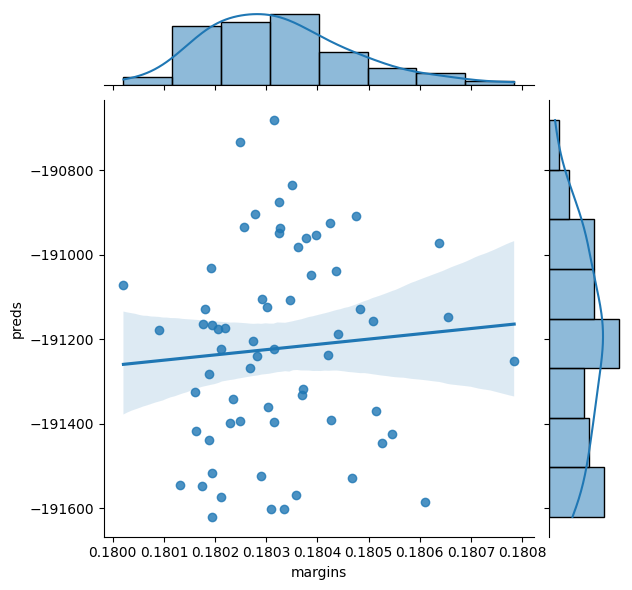

In [37]:
import seaborn as sns
sns.jointplot(data=my_data, x="margins", y="preds", kind="reg")

In [38]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
# k = 48
# margins = lds_testset_correctness[k:]
# infl_est_ = _masked_dot(lds_testset_correctness[:k], lds_mask_array[:k]) - _masked_dot(lds_testset_correctness[:k], ~lds_mask_array[:k])
# # infl_est_ = _masked_dot(lds_testset_correctness[:], lds_mask_array[:]) - _masked_dot(lds_testset_correctness[:], ~lds_mask_array[:])
# preds = lds_mask_array[k:] @ infl_est_.T

margins = lds_testset_correctness
infl_est_ = -scores_list[1]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.088 (avg p value 0.416369)


In [39]:
my_data = {
    'margins': margins[:, 0],
    'preds': preds[:, 0]
}

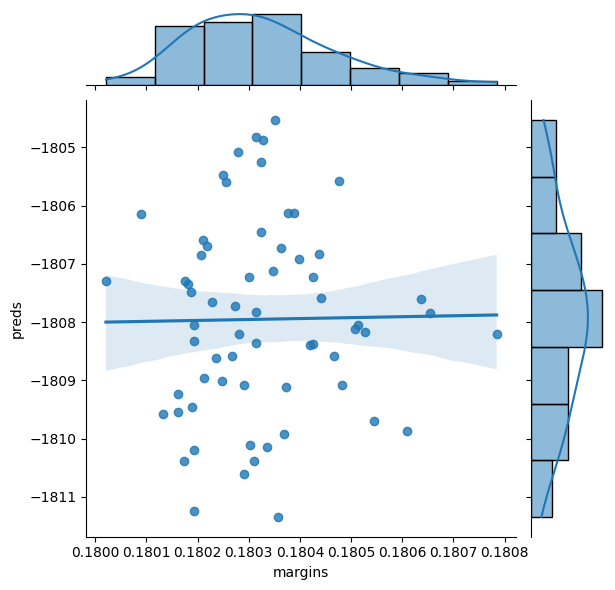

In [40]:
import seaborn as sns
sns.jointplot(data=my_data, x="margins", y="preds", kind="reg")

In [41]:
scores = scores_list[1]

In [42]:
i = 0

In [43]:
D = -scores[i]
D.shape

(5000,)

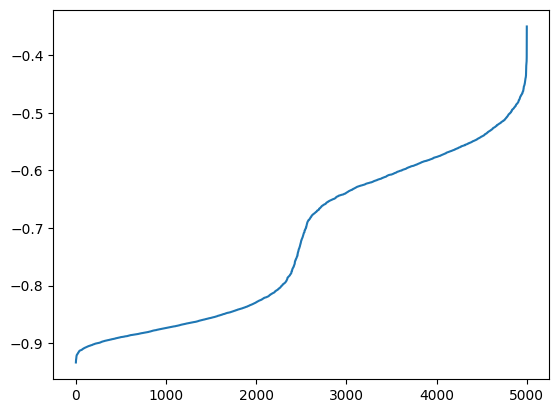

In [44]:
plt.plot(sorted(D))
# plt.axhline(y=0, c='red')

In [45]:
topK = np.arange(5000)[D.argsort()[0:5]]
topK

array([4849, 1310, 1342, 3550, 3506])

In [46]:
plot_images = []
plot_images.append(val_dataset[i]['image'])
for idx in topK:
    plot_images.append(train_dataset[int(idx)]['image'])

In [47]:
val_artist = ''
val_artist

''

In [48]:
train_artist = []
for k in topK:
    tmp_artist = ''
    train_artist.append(tmp_artist)
train_artist   

['', '', '', '', '']

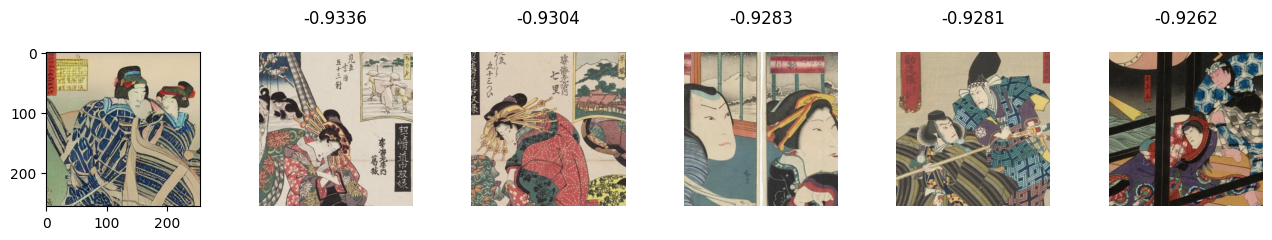

In [49]:
# full
show_images(plot_images, D[D.argsort()[0:5]], val_artist, train_artist)